# Global Imports

In [29]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random
from collections import defaultdict

random.seed(42)

# Local Imports

In [30]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.character_dataset import CharImageDataset
from models.allcnn2d import AllCNN2D

# Globals

In [31]:
DATASET_SPLIT: float = 0.8
MODEL_NAME: str = "Hotel"
LOAD_CHECKPOINT: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\checkpoints\GeckoFull_epoch1980_trainacc0.90605_valacc0.98089_Tloss0.78068_Vloss0.20101_lr6.320194197753456e-11.pkl"

# Define Paths
Workspace

In [32]:
notebook_dir: str = os.path.abspath(".")
root_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir
)

data_dir: str = os.path.join(
    root_dir,
    "data",
    "lambda"
)

model_save_dirpath: str = os.path.join(
    root_dir,
    "models",
    "allcnn"
)


Image paths

In [33]:

images_path_glob: str = os.path.join(
    data_dir,
    "u*.png"
)
images_path_regex: str = r"(u[0-9a-fA-F]+)-([0-9]+)\.png"

image_paths: list[str] = glob.glob(images_path_glob)
random.shuffle(image_paths)


# Helper Functions

In [34]:
def get_current_time() -> str:
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Logging Setup 

In [35]:

logging_path: str = f"{MODEL_NAME}_log_{get_current_time()}.csv"

with open(logging_path, "w") as f:
    f.write("TIME,EPOCH,TRAIN_ACC,VAL_ACC,TRAIN_LOSS,VAL_LOSS,LR\n")

def log(
    epoch: int,
    train_acc: float, 
    train_loss: float, 
    val_acc: float, 
    val_loss, 
    lr: float
)-> None:
    with open(logging_path, "a") as f:
        f.write(f"{get_current_time()},{epoch},{train_acc},{val_acc},{train_loss},{val_loss},{lr}\n")

# Extract Labels From File Names

In [36]:


labeled_image_paths: list[tuple[str, str]] = []

class_counts: dict[str, int] = defaultdict(lambda: 0)

file_path: str
for file_path in image_paths:
    match = re.search(images_path_regex, file_path)
    
    if not match:
        continue
    
    u_hexvalue: str = match.group(1)
    
    class_counts[u_hexvalue] += 1
    
    
    labeled_image_paths.append((u_hexvalue, file_path))

labels: list[str]
image_paths: list[str]
labels, image_paths =  list(zip(*labeled_image_paths))


# Balance Classes Using Oversample

In [37]:
sorted_counts: list[tuple[str, int]] = sorted(
    class_counts.items(), 
    key=lambda x: x[0]
)

counts: list[int] = [pair[1] for pair in sorted_counts]

max_count: int = max(counts)

to_add_counts: dict[str, int] = {
    uid: max_count - count 
    for uid, count in 
    sorted_counts
}

total_items = sum(x[1] for x in sorted_counts)


In [38]:
total_items

887

In [39]:
max_count

49

In [40]:
print(*to_add_counts.items())

('u28', 1) ('u29', 1) ('u2b', 0) ('u2d', 37) ('u2e', 0) ('u30', 34) ('u31', 0) ('u32', 34) ('u33', 34) ('u34', 34) ('u35', 34) ('u36', 34) ('u37', 34) ('u38', 34) ('u39', 34) ('u3bb', 0) ('u61', 0) ('u62', 34) ('u63', 34) ('u64', 34) ('u65', 34) ('u66', 34) ('u67', 34) ('u68', 34) ('u69', 34) ('u6a', 34) ('u6b', 34) ('u6c', 34) ('u6d', 34) ('u6e', 34) ('u6f', 34) ('u70', 34) ('u71', 34) ('u72', 34) ('u73', 34) ('u74', 34) ('u75', 34) ('u76', 34) ('u77', 34) ('u78', 34) ('u79', 34) ('u7a', 34) ('ud7', 37) ('uf7', 37)


In [41]:
to_add_labels: list[str] = []
to_add_file_paths: list[str] = []

while True in [to_add_count>0 for to_add_count in to_add_counts.values()]:  
    for label, image_path in zip(labels, image_paths):
        remaining: int = to_add_counts[label]
        
        if remaining > 0:
            to_add_labels.append(label)
            to_add_file_paths.append(image_path)
            to_add_counts[label] -= 1

In [42]:
print(*to_add_labels)
print(*to_add_file_paths)

u29 u33 u6b u70 u37 u75 u33 u6b u76 u76 u69 u71 u73 u66 u34 u70 u6a u28 u39 u66 uf7 u7a u74 u78 u69 u64 u2d u68 u38 u65 u63 u2d u6f u6e u64 u67 u35 u62 u6d u72 u6f u6c u71 u39 u6e u78 u36 u6e u75 u77 u78 u2d u70 u64 u77 u34 u70 uf7 u72 u70 u62 u74 u37 u71 u69 u76 u71 u67 u39 u70 uf7 u72 u38 u63 u39 u63 u66 u71 u65 u70 u73 u76 u70 u35 u37 ud7 u69 u62 u38 u39 u63 u6b u69 ud7 u7a u6c u79 u6b u75 u62 u62 u6a u71 u79 u34 u7a u6c u32 u79 u69 u36 u77 u76 u75 u73 u32 u6b u65 u77 u67 u65 u35 u37 u63 u79 u7a u70 u72 u37 u77 u79 u35 u6c u6f u66 u38 u36 u35 u37 u63 u36 u68 u38 u65 u33 u33 u6f u2d u71 u6b u2d u33 u35 u30 u69 u6f u72 ud7 u68 u71 u38 u6c u72 u6f u34 u36 u6c u69 u6b u38 u62 u76 u34 uf7 u6f u74 u6d u34 u67 ud7 uf7 u72 u74 u68 u34 u6d u6a u6b u33 u30 u77 u6c u62 u2d u69 u39 u63 u65 u72 u77 u77 u73 u2d u38 u32 u30 u2d u64 u35 ud7 u73 u30 u6a u32 u2d u30 u75 u6e u73 u67 u2d u36 u64 u6d u36 u6a u73 u36 u63 u32 u6f u6a u78 u33 u77 u34 ud7 u76 u67 u75 u77 u62 u33 u69 u67 u6e u74 u6a u6a u35 

# Load Dataset

In [45]:

split_index: int = int(len(image_paths)*DATASET_SPLIT)
all_label_classes: list[str] = list(set(labels))

train_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=list(image_paths[:split_index]) + to_add_file_paths,
    labels=list(labels[:split_index]) + to_add_labels,
    all_label_classes=all_label_classes,
    rotation_limit=0.02,
    translation_limit=0.2,
    skew_limit=0.06,
    zoom_change=1.0,
    min_zoom=0.8,
    thicken_sigma=1.75,
    image_dims=(64, 64)
)

val_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[split_index:],
    labels=labels[split_index:],
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    min_zoom=1.0,
    thicken_sigma=1.75,
    image_dims=(64, 64)
)




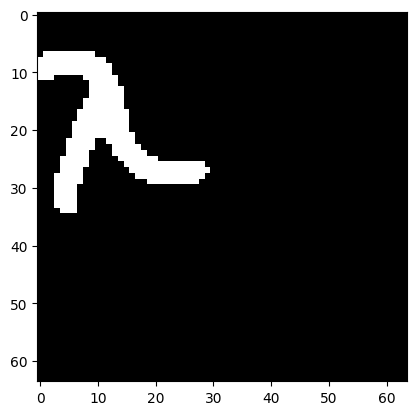

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


In [46]:
for im, lab in train_char_dataset:
    plt.imshow(
        rearrange(im, "1 h w -> h w")*255, 
        cmap="gray"
    )
    plt.show()
    print(lab)
    break

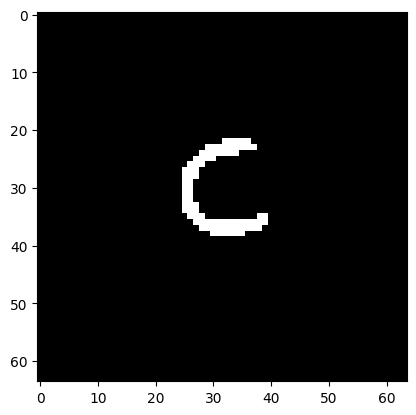

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


In [47]:
for im, lab in val_char_dataset:
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

# Load DataLoader

In [48]:
train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=16
)

val_dataloader: DataLoader = DataLoader(
    val_char_dataset,
    shuffle=False,
    batch_size=16
)

In [49]:
len(class_counts.keys())

44

# Define Model Hyperparameters

In [50]:


all_model_parameters: list[dict[str, Any]] = [
    {
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": LOAD_CHECKPOINT
    }
]

all_optim_parameters: list[dict[str, Any]] = [
    {
        "lr": 0.001,
        "weight_decay": 0.0001
    }
]


In [51]:
len(val_dataloader)

12

# Train

In [ ]:


epoch_log: EpochLogs
for epoch_log in grid_search(
    model_factory=AllCNN2D,
    all_model_parameters=all_model_parameters,
    optim_factory=AdamW,
    all_optim_params=all_optim_parameters,
    epochs=10000,
    criterion=nn.CrossEntropyLoss(),
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    lr_decay_window_size=10,
    lr_decay_minimum=0.0,
    scheduler_scale=0.85,
    device="cuda"
):
    train_logpoints: list[LogPoint] = epoch_log.train_logs
    val_logpoints: list[LogPoint] = epoch_log.val_logs
    
    
    train_count: int = 0
    val_count: int = 0
    
    train_losses_tally: float = 0.0
    val_losses_tally: float = 0.0
    
    train_correct_tally: int = 0
    val_correct_tally: int = 0
    
    for log_point in train_logpoints: 
        
        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat, 
            axis=-1
        ).detach().cpu()
        
        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()

        
        train_is_correct = y_hat_pred==y_pred
        train_correct_tally += torch.sum(train_is_correct)
        
        train_losses_tally += torch.sum(log_point.loss)
        
        train_count += len(y_hat_pred)
        
    for log_point in val_logpoints: 
        
        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat, 
            axis=-1
        ).detach().cpu()
        
        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()

        val_correct_tally += torch.sum(y_hat_pred==y_pred)
        
        val_losses_tally += torch.sum(log_point.loss)
        
        val_count += len(y_hat_pred)
        
    train_accuracy: float = train_correct_tally/train_count
    val_accuracy: float = val_correct_tally/val_count
    
    train_loss: float = train_losses_tally/train_count
    val_loss: float = val_losses_tally/val_count
    
    cur_learning_rate: float = epoch_log.optimiser.param_groups[0]["lr"]
    
    model_checkpoint_path: str = os.path.join(
        model_save_dirpath,
        f"{MODEL_NAME}_epoch{epoch_log.epoch}_trainacc{train_accuracy:.5}_valacc{val_accuracy:.5}_Tloss{train_loss:.5}_Vloss{val_loss:.5}_lr{cur_learning_rate}.pkl"
    )
    
    with open(model_checkpoint_path, "wb") as f:
        torch.save(epoch_log.model.state_dict(), f)
    
    print(f"Train Accuracy      : {train_accuracy}")
    print(f"Val Accuracy        : {val_accuracy}")
    print(f"Loss                : {train_loss}")
    print(f"Val Loss            : {val_loss}")
    print(f"Learning Rate       : {cur_learning_rate}")
    
    log(
        epoch_log.epoch,
        train_accuracy,
        train_loss,
        val_accuracy,
        val_loss,
        cur_learning_rate
    )

Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

Validating Model...: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]
